In [1]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

# Mask
method_list = ["UCS_10X", "Nuclei_Cellpose", "Nuclei_10X", "Cell_10X", "BIDCell", "Baysor"]

In [2]:
mask_dict = {}
df_dict = {}
ad_st_dict = {}
boundary_dict = {}
for method in method_list:
    mask = tifffile.imread(config.segmentation_results[method])
    df = pd.read_csv(os.path.join(config.output_dir, f"{method}_cell_feature.csv"), index_col=0)
    ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method}/annotated_adata_st.h5ad")
    mask_dict[method] = mask
    boundary_dict[method] = find_boundaries(mask, mode='inner')
    df_dict[method] = df
    ad_st_dict[method] = ad_st

In [3]:

# Load other
he = tifffile.imread(config.he)
dapi = tifffile.imread(config.dapi)

gene_map = tifffile.imread(config.gene_map)
gene_map_sum = gene_map.sum(axis=2)
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [x.strip() for x in gene_names]

## PCA

In [7]:
# SCRNA
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/Cell_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]
sc.pp.scale(ad_sc, max_value=10)
sc.tl.pca(ad_sc, n_comps=25)
pcs = ad_sc.varm['PCs']

In [10]:
import seaborn as sns

def plot_st(method):
    ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method}/annotated_adata_st.h5ad")
    # Sort the gene
    ad_st = ad_st[:, ad_sc.var.index]
    sc.pp.scale(ad_st, max_value=10)
    ad_st.obsm['X_pca'] = (ad_st.X - ad_sc.X.mean(0)) @ pcs
    ad_st.varm['PCs'] = pcs
    ad_all = ad_sc.concatenate(ad_st)
    ad_all.varm['PCs'] = pcs
    ad_all.raw = ad_all
    sc.pp.neighbors(ad_all, n_neighbors=15, metric = 'cosine', n_pcs=20)
    sc.tl.umap(ad_all, min_dist = 0.5, spread = 1., maxiter = 80)

    df = pd.DataFrame(ad_all.obsm['X_umap'], columns = ['x', 'y'])
    color_mu = ['SC' for i in range(ad_all.shape[0]- ad_st.shape[0])]+\
                ['ST' for i in range(ad_st.shape[0])]
    df['Label'] = color_mu

    fig, ax = plt.subplots(1,2,figsize=(15,7.5))

    sns.scatterplot(data=df, x="x", y="y", hue="Label", s=2, palette = ['#a1c9f4','#c44e52'],ax=ax[0])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_xlabel('UMAP1')
    ax[0].set_ylabel('UMAP2')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].legend(loc="upper left",framealpha=0,markerscale=2,handletextpad=0.2)

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    sc.pl.umap(ad_all, color=["C_scANVI"], size=15,
               color_map = 'RdPu', ncols = 1, na_in_legend=False, legend_loc='on data',
               legend_fontsize=10,title='',palette=sc.pl.palettes.default_20,ax=ax[1])
    plt.show()
    return ad_all

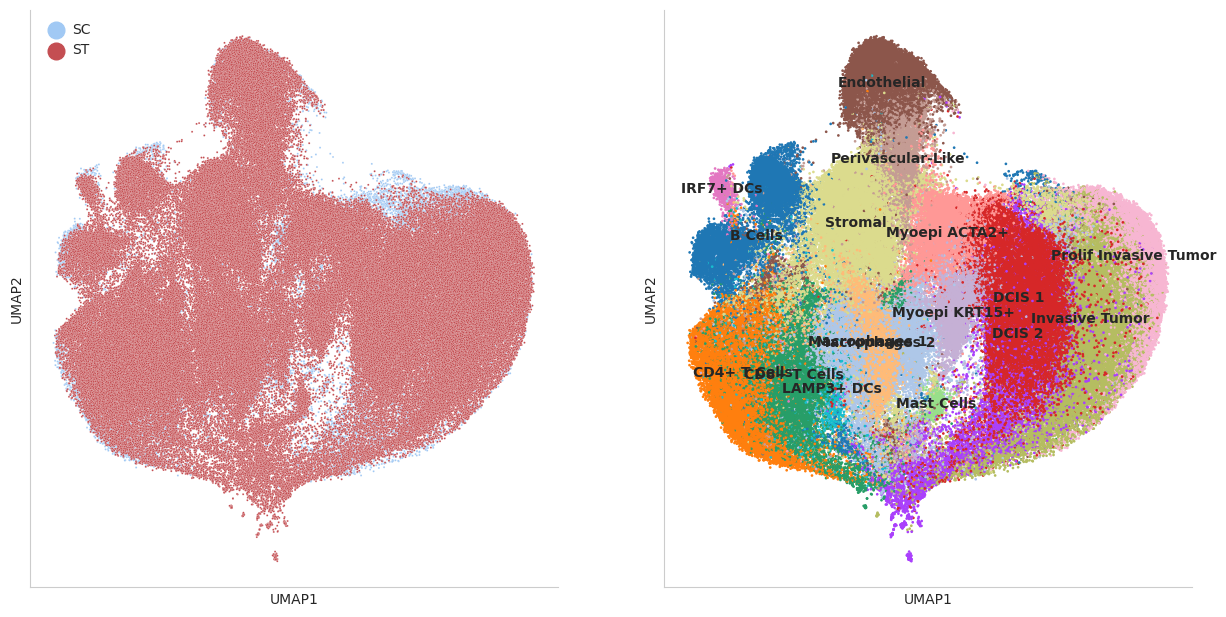

In [11]:
ad_all_ucs = plot_st("UCS_10X")

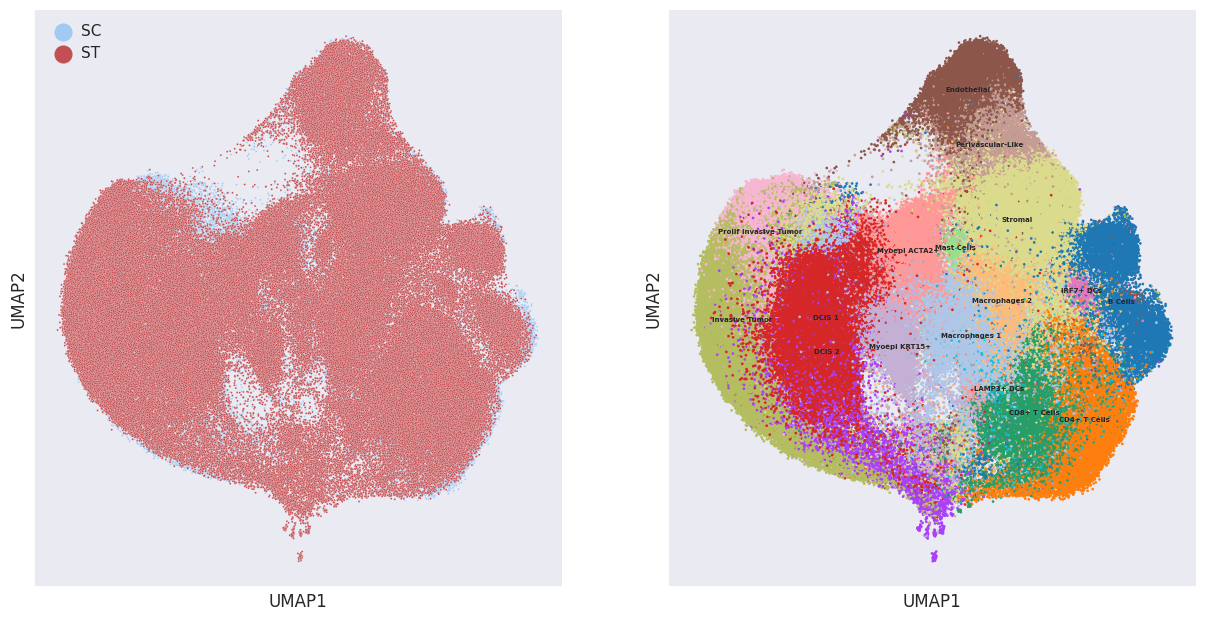

In [65]:
ad_all_10x = plot_st("Cell_10X")

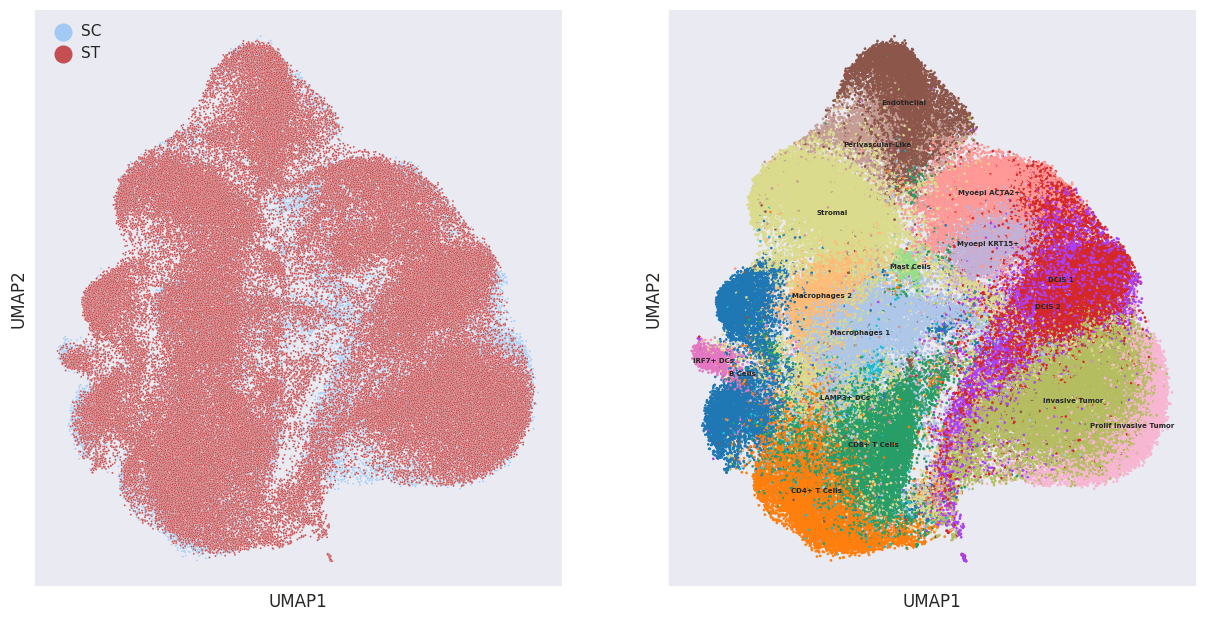

In [66]:
ad_all_bidcell = plot_st("BIDCell")

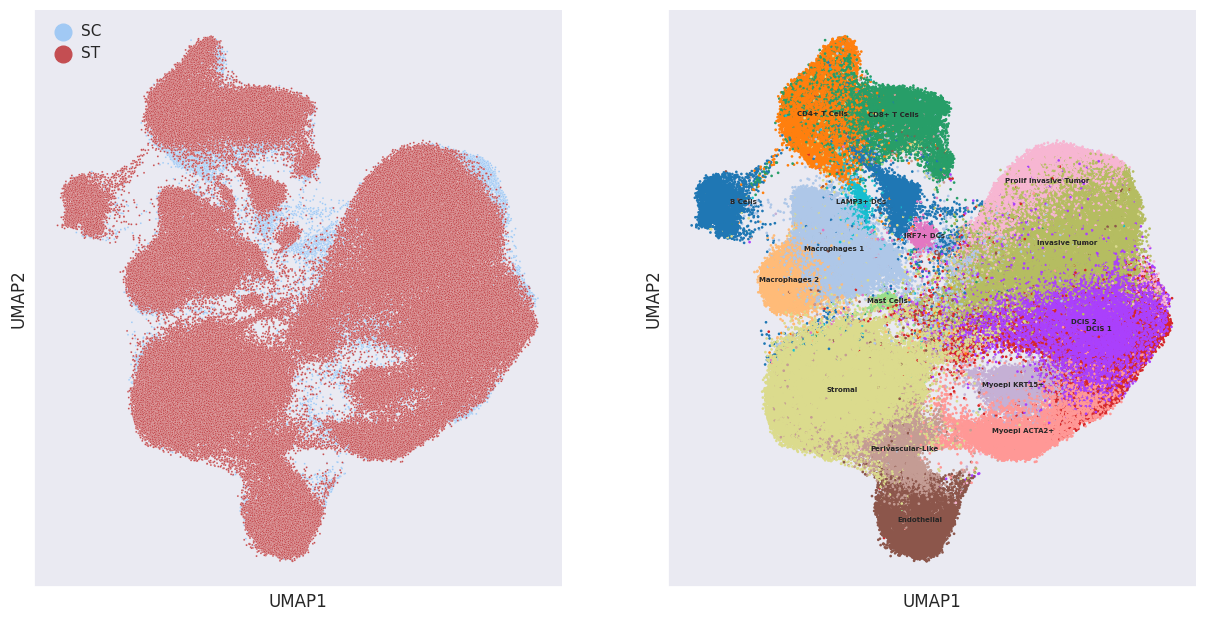

In [67]:
ad_all_baysor = plot_st("Baysor")

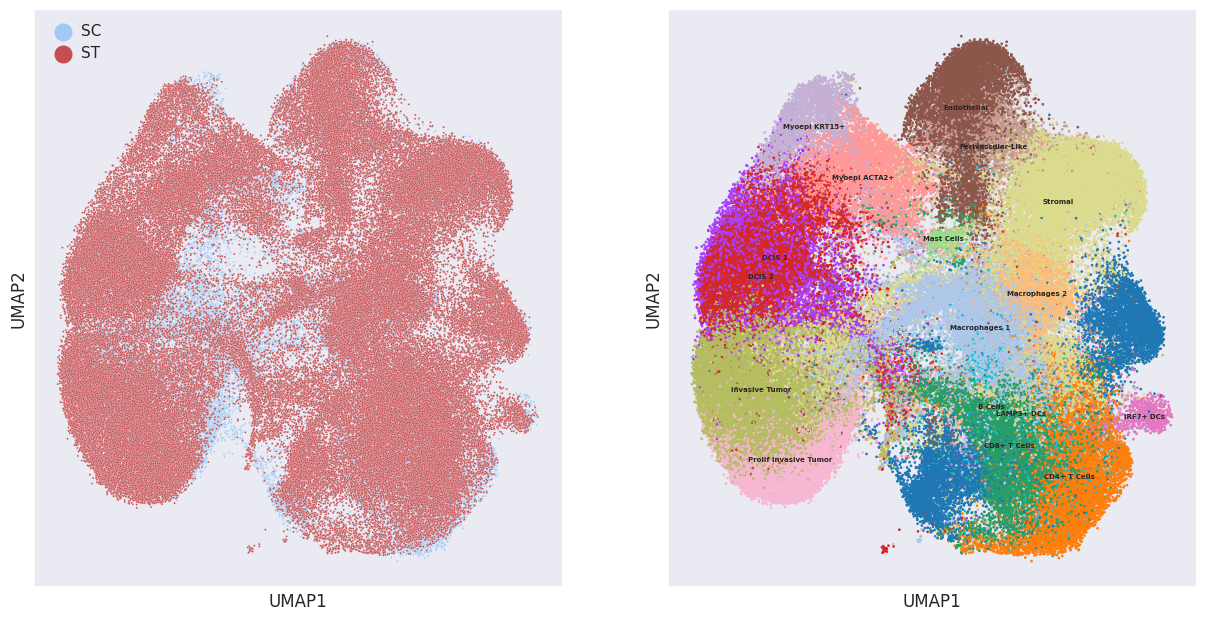

In [68]:
ad_all_ucs_cellpose = plot_st("UCS_Cellpose")

In [ ]:
ad_all_10x_nuclei = plot_st("Nuclei_10X")